In [5]:
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy.linalg as la
import scipy.sparse as sparse
from scipy.sparse.linalg import LinearOperator
from scipy.fft import fft, ifft, fft2, ifft2, fftfreq, fftshift, ifftshift
from scipy.optimize import minimize
# from sklearn import datasets
from scipy.stats import multivariate_normal, norm

In [1]:
class Op:
    def __init__(self, fun, jac, shape):
        self.eval = fun
        self.jac = jac
        self.shape = shape

def objective_1D(z, y, A, G, w=1, lmbda = 0):
    '''
    LS objective
        (0.5)*\|A(G(z)) - y\|_2^2 + 0.5*lmbda**2*\|w*z\|_2^2
    
    input

        w - option to put in more variation like Tikhonov?

    '''
    # to do implement size checks for A, z, G
    k  = len(z)//2
    zc = z[:k] + 1j*z[k:]

    # evaluations of G
    xc = G.eval(zc)
    Dx = G.jac(zc)

    # evaluations of A
    yp = A.eval(xc)
    Dy = A.jac(xc)

    # compute value and gradient least squares
    val    = (0.5)*np.linalg.norm(yp - y)**2 + (0.5*lmbda**2)*np.linalg.norm(w*zc)**2
    gradc   = Dx.H(Dy.H@(yp - y)) + (lmbda**2)*(w*w)*zc

    grad  = np.concatenate((np.real(gradc), np.imag(gradc)))

    return val, grad

def reconstruct(xtrue, A, G, w=1, sigma=0, lmbda=0):
    # sizes
    m,n = A.shape
    n,k = G.shape
    
    # generate data
    yobs  = A.eval(xtrue) + sigma*np.random.randn(m)

    # inference
    result = minimize(objective_1D, x0=np.ones(2*k), args=(yobs, A, G, w, lmbda), method='L-BFGS-B', jac=True)
    
    # extract complex values
    zhat = result.x[:k] + 1j*result.x[k:]
    xhat = G.eval(zhat)
    
    # correct global phase 
    phi = np.mean(np.angle(xtrue/xhat))
    xhat_corr = np.exp(1j*phi)*xhat
    
    # relative error
    error = np.linalg.norm(xhat_corr - xtrue)/np.linalg.norm(xtrue)
    
    # return
    return error, xhat_corr, zhat

In [2]:
def MaskedFourier_1D(M):
    '''
    Masked 1D fourier transform as a linear operator.

    input:
        M - 2D array of size n x m containing m windows of length n
    
    output:
        A - linear operator representing the masked Fourier transforms

    '''
    nx = M.shape[0] # length of window
    mx = M.shape[1] # number of windows

    mv  = lambda x : fft(M*x[:, None], axis=0).flatten()
    rmv = lambda y: np.sum(ifft(y.reshape((nx, mx)), axis=0) * np.conj(M), axis=1).flatten()
    
    A = LinearOperator((nx*mx, nx), matvec=mv, rmatvec = rmv)

    return A

def block_signal(length,starts,heights,widths):
    '''
    input:
        lentgh signal, start (integer index), height, width (integer ndices)
    '''
    nsamples = len(starts)
    signals = np.zeros((nsamples, length))

    for i in range(nsamples):
        start = int(starts[i])
        width = int(widths[i])
        height = heights[i]
        end = min(start + width, length-10)  # Ensure block stays within bounds
        signals[i, start:end] = height
        
    return signals

def cut_off_lowpass(data, highcut):
    data = np.atleast_2d(data)
    n = data.shape[1] # will not go well if X is higher dim
    k = fftfreq(n,1)
    cut_off = np.where((k < -highcut ) | (k > highcut))[0]
    
    data_fft = fft(data)
    data_fft[:,cut_off] = 0
    new_data = np.real(ifft(data_fft, axis=1)) # also only works for real data
    return (new_data, cut_off) if data.shape[0] > 1 else (new_data[0], cut_off)

def sine_signal(n, frequencies):
    '''
    input: grid length, frequencies (nsamples x 3), time
    '''
    nsamples = frequencies.shape[0]
    t = np.linspace(0, 1, n, False)  # 1 second

    signals = np.zeros((nsamples,n))
    for i in range(nsamples):
        signals[i] = np.sin(2*np.pi*frequencies[i,0]*t) + np.sin(2*np.pi*frequencies[i,1]*t) + np.sin(2*np.pi*frequencies[i,2]*t)
        norm = la.norm(signals[i])
        signals[i] = signals[i]/norm
    
    return signals

# 1D ambiguity function
def Ambiguity(phi,m): #for now, ignore specific frequency component n and compute all
    '''
    input:
        phi - signal of length L
        m - shift of the signal
    output:
        Fourier vector of the signal multiplied by its conjugate shift
    '''
    shift_phi = np.conjugate(np.roll(phi,m))
    return fft(phi*shift_phi)

def ambiguityconst(windows):
    '''
    input:
        windows     window functions (length, number of windows/measurements)
    '''
    mx = len(windows[0,:])
    c = 0
    for i in range(2):
        for j in range(mx): 
            mask_test = Ambiguity(windows[:,j], i)
            temp_max = 1/abs(mask_test).min() #potential hazard of dividing by small numbers
            if temp_max > c:
                c = temp_max
                remember_mask_index = j
    return c, remember_mask_index

# compute stability constant
def stabilityconst(n, x, delta, c):
    '''
    input:
        n       signal gridsize
        x       signal set, specified as (number of samples, length of sample)
        delta   threshold
        c       ambiguity function threshold   
    output:
        constant bound for reconstruction
    '''
    max_norm = np.max(np.linalg.norm(x, axis = 1)) # along rows
    C = c/delta*(1 + np.sqrt(2*n*max_norm)/delta)
    return C

In [3]:
# define experiment
def run_experiment(Xtrue, A, G, sigmas):
    nsigmas = len(sigmas)
    k       = G.shape[1]
    Xhat    = np.zeros((n,nsamples,nsigmas),dtype=complex)
    errors  = np.zeros((nsamples,nsigmas))
    zhat    = np.zeros((k,nsamples,nsigmas),dtype=complex)
    
    for i in range(nsamples):
        for j in range(nsigmas):
             errors[i,j], Xhat[:,i,j], zhat[:,i,j] = reconstruct(Xtrue[i,:], A, G, sigma = sigmas[j])
    
    return Xhat, errors, zhat

def plot_experiment(Xhat, errors, Xtrue, sigmas):
    nsigmas = len(sigmas)
    
    fig,ax  = plt.subplots(nsigmas,5,sharey=True)

    for j in range(nsigmas):
        for i in range(5):
            ax[j,i].plot(domain,Xtrue[i,:],'k--')
            ax[j,i].plot(domain,np.real(Xhat[:,i,j]),'r')
            ax[j,i].set_ylim([0,1])
            ax[j,i].set_aspect(1)

    fig.tight_layout()
    plt.show()
    print('sigma    | error (std)')
    for j in range(nsigmas):
        print('%1.2e | %1.2e (%1.2e)'%(sigmas[j],np.mean(errors[:,j]),np.std(errors[:,j])))

In [6]:
# parameters
delta    = 0.1 # threshold
nsamples = 5  # number of samples to generate for validation
n        = 100  # grid size for signal
mx       = 100 # number of measurements
bandwidth = .35 # relative bandwidth for generative model \in (0,1]
sigmas   = [1e-3, 1e-2, 1e-1, 1e3] # noise levels to use for validation

# grid
domain   = np.linspace(0,1,n)

(5, 100)


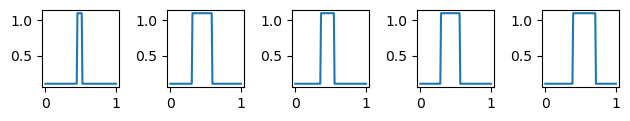

In [7]:
# create data set of a block signal with threshold delta bounded away from 0
heights  = np.ones(nsamples)
starts   = np.random.randint(10,n-20,nsamples)
widths   = np.random.randint(5,n/2,nsamples)

Xtrue = block_signal(n,starts,heights,widths) + delta
print(Xtrue.shape)

fig,ax = plt.subplots(1,5)

for i in range(5):
    ax[i].plot(domain,Xtrue[i,:])
    ax[i].set_aspect(1)

fig.tight_layout()
plt.show()

-0.002250646783365312
31


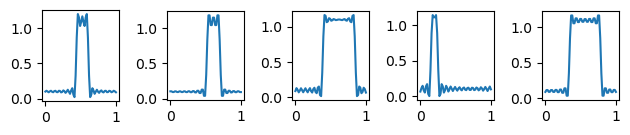

In [ ]:
# plot the fourier frequencies of the block signal data set
X_filtered, cut_indices = cut_off_lowpass(Xtrue,bandwidth)
threshold_value = np.min(X_filtered)
print(threshold_value)
print(len(cut_indices))

fig,ax = plt.subplots(1,5)

for i in range(5):
    ax[i].plot(domain,X_filtered[i,:])
    ax[i].set_aspect(1)

fig.tight_layout()
plt.show()

(5, 100)
0.2350880637889691


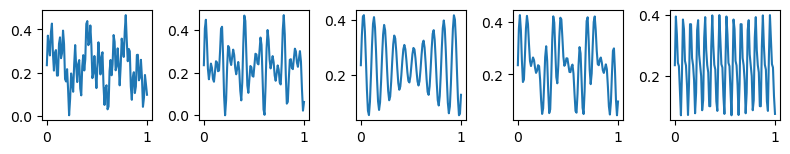

0.01
0.47028245868221097
0.0001
0.01


In [8]:
# (low freq sines) create data set 
frequencies = np.random.randint(2,30, size=(nsamples,3))

Xlowfreq = sine_signal(n,frequencies)
print(Xlowfreq.shape)
smallest = np.abs(np.min(Xlowfreq))
print(smallest)
#print(np.min(Xtrue), np.max(Xtrue))

Xlowfreq = Xlowfreq + smallest

fig,ax = plt.subplots(1,5, figsize=(8, 2))
#fig,ax = plt.subplots(1,5)

for i in range(5):
    ax[i].plot(domain,Xlowfreq[i,:])
    #ax[i].set(aspect='equal')
    ax[i].set_box_aspect(1)

fig.tight_layout()
plt.show()

# make complex phase retrieval set
Xlowfreq_complex = 0.01*np.ones((nsamples,n)) + 1j*Xlowfreq

smallest = np.min(np.abs(Xlowfreq_complex))
print(smallest)
print(np.max(np.abs(Xlowfreq_complex)))

print(smallest**2)
print(1/n)

[ 0.        0.015625  0.03125   0.046875  0.0625    0.078125  0.09375
  0.109375  0.125     0.140625  0.15625   0.171875  0.1875    0.203125
  0.21875   0.234375  0.25      0.265625  0.28125   0.296875  0.3125
  0.328125  0.34375   0.359375  0.375     0.390625  0.40625   0.421875
  0.4375    0.453125  0.46875   0.484375 -0.5      -0.484375 -0.46875
 -0.453125 -0.4375   -0.421875 -0.40625  -0.390625 -0.375    -0.359375
 -0.34375  -0.328125 -0.3125   -0.296875 -0.28125  -0.265625 -0.25
 -0.234375 -0.21875  -0.203125 -0.1875   -0.171875 -0.15625  -0.140625
 -0.125    -0.109375 -0.09375  -0.078125 -0.0625   -0.046875 -0.03125
 -0.015625]


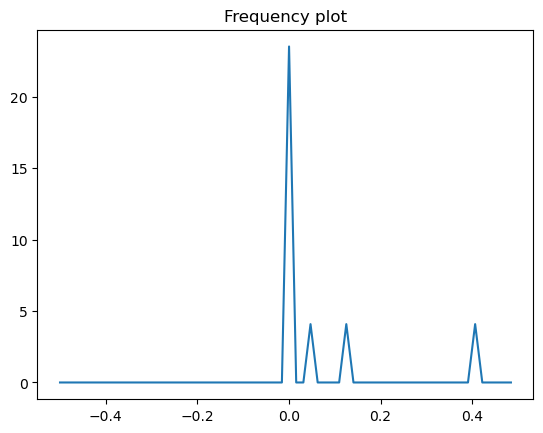

In [9]:
## delete: this is a test to reunderstand the frequencies
index = 0
X_fft = fft(Xlowfreq[index])
amplitudes = abs(X_fft)
ktemp = fftfreq(64,1)
print(ktemp)

sorted_indices = np.argsort(ktemp)
ktemp = ktemp[sorted_indices]
amplitudes = amplitudes[sorted_indices]

plt.figure()
plt.plot(ktemp, amplitudes)
plt.title("Frequency plot")
plt.show()

The value of c is 940.797975893748
Lowest threshold of the ambiguity function is 0.0010629274569282643
The mask with the lowest ambiguity threshold is 84


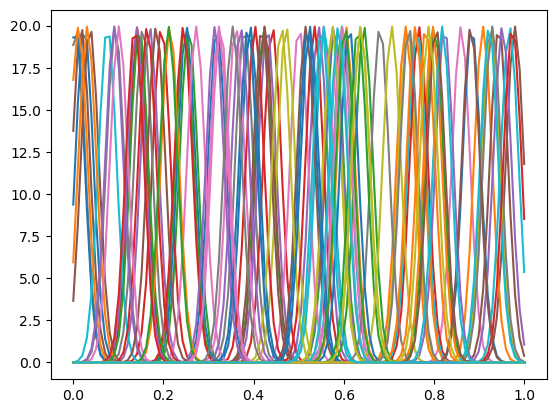

In [10]:
# describes mx window functions of length n
windows = np.zeros((n,mx))
mu      = np.random.uniform(0,1,mx)
windows = norm.pdf(domain[:, np.newaxis], mu, .02) # do not use a high variance, leads to small values ambiguity function

# make into n x n x mx matrix
M = np.zeros((n,n,mx))
for i in range(mx):
    M[:,:,i] = np.diag(windows[:,i])

# calculate threshold value of the ambiguity
c, mask_index = ambiguityconst(windows)
print("The value of c is", c)
print("Lowest threshold of the ambiguity function is", 1/c)
print("The mask with the lowest ambiguity threshold is", mask_index)

fig, ax = plt.subplots()
ax.plot(domain,windows)
plt.show()

In [11]:
# define operators
m    = mx * n
MF   = MaskedFourier_1D(windows)
Afun = lambda x : np.abs(MF@x)**2
Ajac = lambda x : LinearOperator((m, n), matvec=lambda z : 2*(MF@x)*np.conj(MF@np.conj(z)), rmatvec=lambda z : 2*(MF.H@((MF@x)*z)))
A    = Op(fun = Afun, jac = Ajac, shape=(m,n))

freq   = fftfreq(n)
S      = np.eye(n)[:,np.abs(freq)<=bandwidth/1.1]
k      = S.shape[1]
Gfun   = lambda z : delta + ifft(S@z)
Gjac   = lambda p : LinearOperator((n,k), matvec = lambda z : ifft(S@z), rmatvec = lambda x : (S.T@fft(x))/n)
G      = Op(fun = Gfun, jac = Gjac, shape=(n,k))

I = Op(fun = lambda z : z, jac = lambda z: LinearOperator((n, n), matvec = lambda z : z, rmatvec = lambda z : z), shape=(n,n))

In [ ]:
# define operators for bandwidth experiment
m    = mx * n
MF   = MaskedFourier_1D(windows)
Afun = lambda x : np.abs(MF@x)**2
Ajac = lambda x : LinearOperator((m, n), matvec=lambda z : 2*(MF@x)*np.conj(MF@np.conj(z)), rmatvec=lambda z : 2*(MF.H@((MF@x)*z)))
A    = Op(fun = Afun, jac = Ajac, shape=(m,n))

I = Op(fun = lambda z : z, jac = lambda z: LinearOperator((n, n), matvec = lambda z : z, rmatvec = lambda z : z), shape=(n,n))

def construct_operator(n, bandwidth, adjust, threshold_value=0):
    """
    Constructs the operator G for a given bandwidth and bandwidth adjustment.

    Input:
        n                   int, size of the signal.
        bandwidth           float, bandwidth to define the S operator. Should be the same as bandwidth of X_filtered for testing
        adjust              float, vary between 1 and 10 to set difference with bandwidth of the true signal. 
        threshold_value     float, constant to add in the Gfun operation.

    Ouput:
        G: Operator, constructed operator G.
    """
    freq = fftfreq(n)
    S = np.eye(n)[:, np.abs(freq) <= bandwidth / adjust]
    k = S.shape[1]

    Gfun   = lambda z : threshold_value + ifft(S@z)
    Gjac   = lambda p : LinearOperator((n,k), matvec = lambda z : ifft(S@z), rmatvec = lambda x : (S.T@fft(x))/n)

    return Op(fun=Gfun, jac=Gjac, shape=(n, k))

adjust = np.arange(1,5+0.1,0.1)

operators = []
for a in adjust:
    G = construct_operator(n, bandwidth, a, threshold_value)
    operators.append(G)

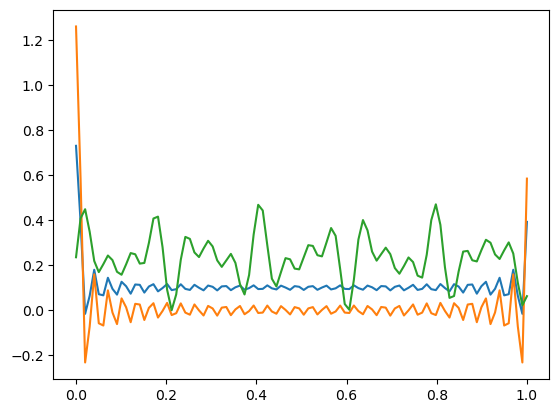

In [ ]:
# for random input, this is the kind of signal the model generates
z = np.random.randn(k) + 1j*np.random.randn(k)
#z = np.ones(k) + 2j*np.ones(k)
plt.plot(domain, np.real(G.eval(z)))
plt.plot(domain, np.imag(G.eval(z)))
plt.plot(domain, Xlowfreq[np.random.randint(0,Xlowfreq.shape[0])])


In [ ]:
Xhat1, errors1, zhat1 = run_experiment(Xlowfreq, A, I, sigmas)

In [ ]:
Xhat2, errors2, _ = run_experiment(Xlowfreq, A, G, sigmas)

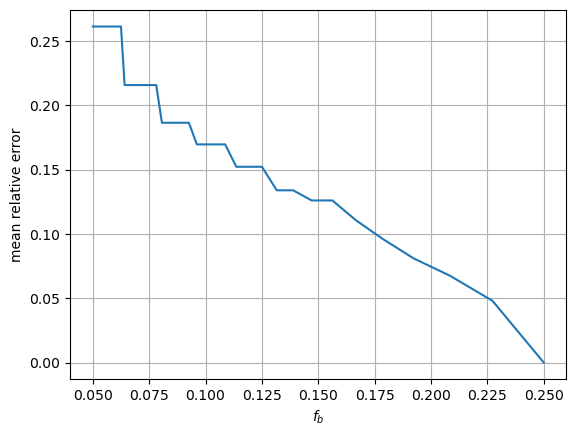

In [ ]:
#Xhat_test,errors_test,zhat2 = run_experiment(X_filtered, I, G, [0,0])

# in this case, Xhat_test = G(z0), so errors_test = |G(z0) - xtrue|/|xtrue| ís the bias
#print(errors_test[0,0])

bias = []
for G in operators:
    _, errors_test, _ = run_experiment(X_filtered, I, G, [0])
    mean_error = np.mean(errors_test)
    bias.append(mean_error)

Xhat_test, errors_test, _ = run_experiment(X_filtered, I, operators[-1], [0,0])
bandwidth_adjusted = bandwidth/adjust

plt.figure()
plt.plot(bandwidth_adjusted,bias)
#plt.title(f"Size of the bias vs the bandwidth of model, true bandwidth = {bandwidth}")
plt.grid()
#plt.yscale("log")
plt.xlabel(r'$f_b$')
plt.ylabel('mean relative error')
plt.show()

In [ ]:
print(len(operators))

21


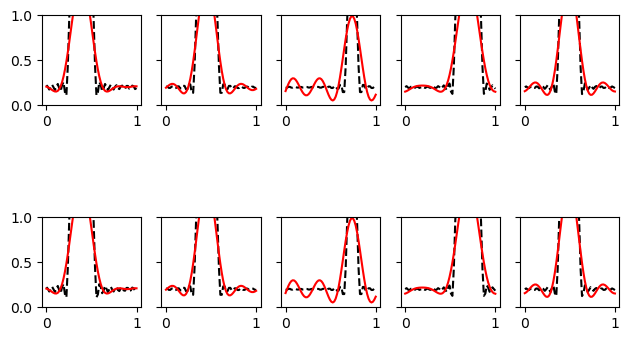

sigma    | error (std)
0.00e+00 | 2.57e-01 (6.04e-02)
0.00e+00 | 2.57e-01 (6.04e-02)


In [ ]:
plot_experiment(Xhat_test, errors_test, X_filtered, [0, 0])

In [ ]:
X_complex = np.ones((5,64)) + 1j*X_filtered
Xhat3, errors3, zhat3 = run_experiment(X_complex, A, I, sigmas)

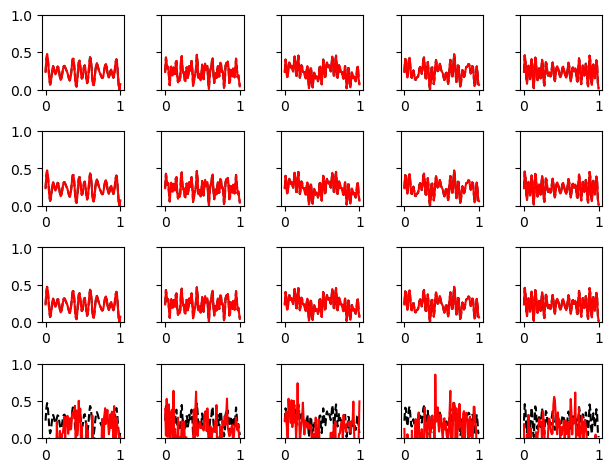

sigma    | error (std)
1.00e-03 | 1.61e-03 (3.12e-03)
1.00e-02 | 5.05e-03 (9.27e-03)
1.00e-01 | 3.97e-03 (3.44e-03)
1.00e+03 | 1.56e+00 (1.03e-01)


In [ ]:
plot_experiment(Xhat1, errors1, Xlowfreq, sigmas)

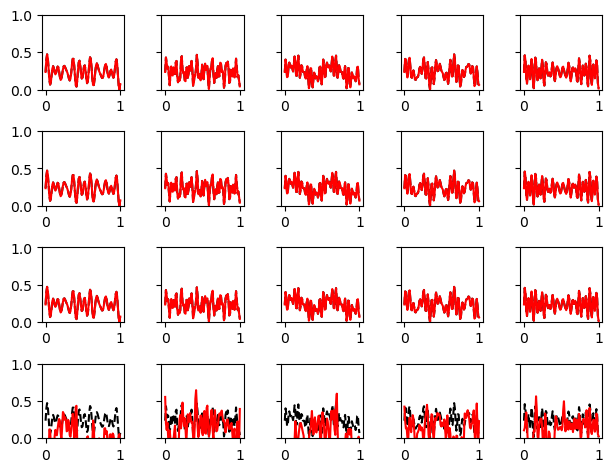

sigma    | error (std)
1.00e-03 | 6.15e-03 (1.23e-02)
1.00e-02 | 3.22e-04 (3.49e-04)
1.00e-01 | 4.40e-04 (2.24e-04)
1.00e+03 | 1.38e+00 (2.17e-01)


In [ ]:
plot_experiment(Xhat2, errors2, Xlowfreq, sigmas) 

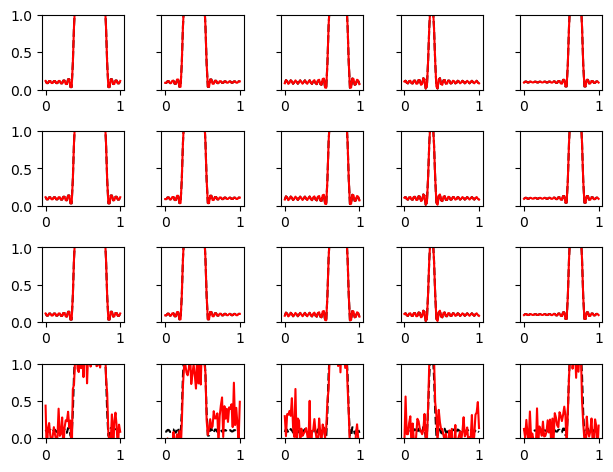

sigma    | error (std)
1.00e-03 | 6.09e-07 (1.21e-07)
1.00e-02 | 6.63e-06 (1.13e-06)
1.00e-01 | 6.16e-05 (1.10e-05)
1.00e+03 | 2.13e-01 (2.03e-02)


In [ ]:
plot_experiment(np.imag(Xhat3), errors3, np.imag(X_complex), sigmas) 